In [16]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit

In [17]:
R = 8.314 # Sets R(gas constant) value in [J/(mol-K)]

In [18]:
def read_ads_data(mof, temperature): # MOF name and temp data was recorded 
    ads_data = pd.read_csv('data/{}_{}C.csv'.format(mof, temperature)) # Reads the isotherm 
    
    ads_data['P/P_0'] = ads_data['RH[%]'] / 100 # Converts the relative humidity to P/P_0
    
    ads_data["A"] = -R * (temperature+273.15) * np.log(ads_data['P/P_0']) # Calculates Polanyi adsorption potential for every point on the graph 

    
    ads_data = ads_data.drop(columns=['RH[%]']) # Gets rid of the Humidity column 
    return ads_data

In [74]:
# Reads all of the different temp MOF 801 isotherms 
ads_data_15 = read_ads_data('MOF_801',15)
ads_data_25 = read_ads_data('MOF_801',25)
ads_data_45 = read_ads_data('MOF_801',45)
ads_data_65 = read_ads_data('MOF_801',65)
ads_data_85 = read_ads_data('MOF_801',85)
ads_data_105 = read_ads_data('MOF_801',105)
 
#combined_df = pd.concat([ads_data_15, ads_data_25, ads_data_45, ads_data_65, ads_data_85,ads_data_105]) # Combines all MOF 801 data into a single dataframe 

In [75]:
ads_data_25 = ads_data_25.sort_values('A') # Sorts the MOF 801 data by A values so it can be plotted and the curve can be calculated 

In [76]:
# NOT HAPPY WITH THIS STEP
#Need a diferent interpolate function (or line of best fit?)
n_of_A = interpolate.PchipInterpolator(ads_data_25['A'], ads_data_25['Water Uptake [kg kg-1]']) # Finds the equation of the characteristic curve 

In [77]:
def calculate_water(T,P_over_P_0): # Given a T and P/P_0 (RH as a fraction of 1, not a percent) 
    A = -R * (T+273.15) * np.log(P_over_P_0) # Calculate the Polanyi potential 
    Rate_H2O = n_of_A(A) # Plot A on the characteristic curve and find the rate of water adsorption 
    
    return(Rate_H2O.item()) # Return amount of water adsorption 

In [78]:
#Source for weather data for Phoenix from 2020-2021
#https://weathersight.io/timeseries

df_weather = pd.read_csv('data/Phoenix_weather_edited_final.csv') # Import csv file that contains weather data 

In [79]:
def weekly_data(week): # Given a week find the weather data 
    
    df_week = df_weather['Week'] == week # narrow the dataframe to the given week 
    T_high = df_weather[df_week]['T_max_mean[C]'].item() # looking into the weekly dataframe, pull data value 
    T_low = df_weather[df_week]['T_min_mean[C]'].item() # ""
    Dewp_high = df_weather[df_week]['Max_dewp[C]'].item() # "" 
    Dewp_low = df_weather[df_week]['Min_dewp[C]'].item() # ""
    
    return T_high, T_low, Dewp_high, Dewp_low                        

In [80]:
#Find the saturated vapor pressure from temp and dewp 
#source for formula 
#https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf

def pressure_calculations(T,T_dew): # Given a temperature and a dewpoint temp from the weather data 
    
    P_0 = 6.11 * 10**((7.5*T)/(237.3+T)) #calculate saturation pressure 
    P = 6.11 * 10**((7.5*T_dew)/(237.3+T_dew)) # calculate actual pressure
    P_over_P_0 = P/P_0 # calculate P/P_0, relative humidity as a fraction of 1 
    
    return P_over_P_0 # this should be the only value we need out of this function 

In [81]:
 
def water_daily(week,kg_MOF): # find mass of water depending on weekly avg weather and mass MOF
    
    T_high, T_low, Dewp_high, Dewp_low = weekly_data(week) # extract weather data 
    
    P_over_P_0_high = pressure_calculations(T_high, Dewp_high) # calculate humidity during daily high
    
    P_over_P_0_low = pressure_calculations(T_low, Dewp_low) # calculate humidity during daily low
    
    A_low = -R * (T_low+273.15) * np.log(P_over_P_0_high) # calculate polanyi potential during daily high
    
    A_high = -R * (T_high+273.15) * np.log(P_over_P_0_low) # calculate polanyi potential during daily low
    
    high_water = calculate_water(T_high, P_over_P_0_high)  # calculate adsorption value during daily high
    
    low_water = (calculate_water(T_low, P_over_P_0_low)) # calculate adsorption value during daily low (should be higher than during daily high)
    
    water_rate = low_water - high_water # compare the high and low values to find amount of water kicked off by MOF over the course of a day per kg MOF 
    
    water_mass = water_rate * kg_MOF # multiply by kg MOF to find absolute mass of water produced per day under weekly avg conditions 
    
    print('The mass of water collected by the MOF per day during week', week, 'is',round(water_mass,4),'[kg/day]')

    return water_mass

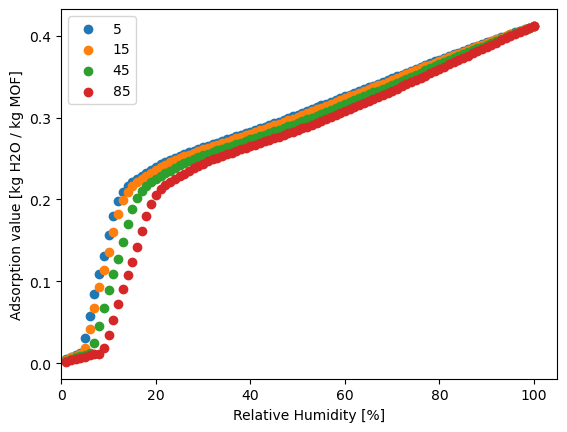

In [95]:
# use water adsorption data and conditions to generate new isotherm curves by temp 
# given T, calculate all A and find ads point, then plot ads vs RH 

def new_isotherm(T):
    
    ads_values = []
    RH_values = []
    
    for i in range(100):
       
        A = -R * (T+273.15) * np.log((i+1)/100) # calculates polanyi potential for given T at given P/P_0
        
        ads = n_of_A(A).item() # finds ads value for given A value 

        RH__current = i+1

        ads_values.append(ads) # add these adsorption values to a list 

        RH_values.append(RH__current)
    
    df_new_isotherm = pd.DataFrame(ads_values, columns=['Adsorption value [kg H2O / kg MOF]']) # create dataframe with the adsorption data 

    df_new_isotherm.insert(0,'Relative Humidity',RH_values) # add RH to the dataframe 

    plt.scatter(df_new_isotherm['Relative Humidity'], df_new_isotherm['Adsorption value [kg H2O / kg MOF]'], label = (T))
    plt.xlabel('Relative Humidity [%]')
    plt.ylabel('Adsorption value [kg H2O / kg MOF]')
    plt.xlim(xmin=0)
    plt.legend()


new_isotherm(5)
new_isotherm(15)
new_isotherm(45)
new_isotherm(85)

    

In [29]:
# then make new file that only needs one MOF isotherm and does this whole thing 
# then make it all one function so it can be optimized? 